## Joins

The first part of this notebook discusses joins in some additional detail. It uses sqlite like lec22 so should run without any special configuration.

In [1]:
import sqlalchemy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Delete the database if it already exists.
from pathlib import Path
dbfile = Path("lec23.db")
if dbfile.exists():
    dbfile.unlink()

sqlite_uri = "sqlite:///lec23.db"
sqlite_engine = sqlalchemy.create_engine(sqlite_uri)

In [3]:
sql_expr = """
CREATE TABLE Sailors (
   sid INTEGER,   
   sname CHAR(20), 
   rating INTEGER, 
   age REAL,
   PRIMARY KEY (sid));
"""
result = sqlite_engine.execute(sql_expr)

In [5]:
sql_expr = """
 CREATE TABLE Reserves (
   sid INTEGER,      
   bid INTEGER, 
   day DATE, 
  PRIMARY KEY (sid, bid, day), 
  FOREIGN KEY (sid) REFERENCES Sailors, 
  FOREIGN KEY (bid) REFERENCES Boats);
"""
result = sqlite_engine.execute(sql_expr)

In [6]:
sql_expr = """
CREATE TABLE Boats (
   bid INTEGER,
   bname CHAR (20), 
   color CHAR(10), 
   PRIMARY KEY (bid));
"""
result = sqlite_engine.execute(sql_expr)


In [7]:
sql_expr = """
INSERT INTO Sailors VALUES
    (22, 'dustin', 7, 45.0),
    (31, 'lubber', 8, 55.0),
    (58, 'rusty', 10, 35.0);
"""
result = sqlite_engine.execute(sql_expr)

In [8]:
sql_expr = """
INSERT INTO Boats VALUES
    (101, 'Nina', 'red'),
    (102, 'Pinta', 'green'),
    (103, 'Santa Maria', 'blue');
"""
result = sqlite_engine.execute(sql_expr)

In [9]:
sql_expr = """
INSERT INTO Reserves VALUES
    (22, 101, '10/10/96'),
    (58, 103, '11/12/96');
"""
result = sqlite_engine.execute(sql_expr)

Once you've run the cells above, we have our basic tables. Reserves and Sailors are shown below.

In [10]:
sql_expr = """
SELECT * FROM Reserves;
"""
pd.read_sql(sql_expr, sqlite_engine)

,sid,bid,day
0,22,101,10/10/96
1,58,103,11/12/96


In [11]:
sql_expr = """
SELECT * FROM Sailors;
"""
pd.read_sql(sql_expr, sqlite_engine)

,sid,sname,rating,age
0,22,dustin,7,45.0
1,31,lubber,8,55.0
2,58,rusty,10,35.0


In [17]:
sql_expr = """
SELECT * FROM boats;
"""
pd.read_sql(sql_expr, sqlite_engine)

,bid,bname,color
0,101,Nina,red
1,102,Pinta,green
2,103,Santa Maria,blue


As we saw in the previous lecture, we can join these tables by specifying two tables in the FROM clause, and setting and equality condition to match the rows from the two tables. The R and S variables that follow the word AS are known as "range variables".

In [12]:
sql_expr = """
SELECT *
    FROM Reserves AS R, Sailors AS S
   WHERE R.sid = S.sid;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,bid,day,sid,sname,rating,age
0,22,101,10/10/96,22,dustin,7,45.0
1,58,103,11/12/96,58,rusty,10,35.0


If we don't provide a WHERE clause, our select statement returns the cartestian product of the two tables.

In [13]:
sql_expr = """
SELECT *
    FROM Reserves AS R, Sailors AS S;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,bid,day,sid,sname,rating,age
0,22,101,10/10/96,22,dustin,7,45.0
1,22,101,10/10/96,31,lubber,8,55.0
2,22,101,10/10/96,58,rusty,10,35.0
3,58,103,11/12/96,22,dustin,7,45.0
4,58,103,11/12/96,31,lubber,8,55.0
5,58,103,11/12/96,58,rusty,10,35.0


When we join a table, we do not have to return every column of course.

In [14]:
sql_expr = """
SELECT R.sid, sname, age
    FROM Reserves AS R, Sailors AS S
   WHERE R.sid = S.sid;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,age
0,22,dustin,45.0
1,58,rusty,35.0


Technically, the "AS" isn't required to define our range variables. It is often omitted in practice. For better or worse, real world SQL implementations generally have fairly loose syntax.

In [15]:
sql_expr = """
SELECT R.sid, sname, age
    FROM Reserves R, Sailors S
   WHERE R.sid = S.sid;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,age
0,22,dustin,45.0
1,58,rusty,35.0


We actually don't need range variables at all, though I don't recommend writing code like this. It's hard to read and needlessly verbose.

In [16]:
sql_expr = """
SELECT Reserves.sid, sname, age
    FROM Reserves, Sailors
   WHERE Reserves.sid = Sailors.sid;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,age
0,22,dustin,45.0
1,58,rusty,35.0


The tables we generated above were all the result of "equi joins". An equi join is a join operation where we use equality to match rows. We can also perform "nonequi joins", which is when we use something other than equality to match rows.

In [18]:
sql_expr = """
SELECT  S1.sname as junior_name, S1.age as junior_age, 
        S2.sname as senior_name, S2.age as senior_age
FROM    Sailors AS S1, Sailors AS S2
WHERE   S1.age < S2.age;"""
pd.read_sql(sql_expr, sqlite_engine) 

,junior_name,junior_age,senior_name,senior_age
0,dustin,45.0,lubber,55.0
1,rusty,35.0,dustin,45.0
2,rusty,35.0,lubber,55.0


There are several ways to write a join in SQL. The version we were doing above with the explicit equality condition in the WHERE clauses is didactically useful for understanding the relationship between a cartesian product and a join. However, in practice, it is more common to write joins with syntax like the example below using "INNER JOIN ... ON".

In [19]:
sql_expr = """SELECT s.sid, s.sname, r.bid
FROM Sailors s, Reserves r
WHERE s.sid = r.sid
AND s.age > 20;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,bid
0,22,dustin,101
1,58,rusty,103


In [22]:
sql_expr = """SELECT s.sid, s.sname, r.bid
FROM Sailors s INNER JOIN Reserves r
ON s.sid = r.sid
AND s.age > 20;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,bid
0,22,dustin,101
1,58,rusty,103


The INNER JOIN format is generally preferred because it separates the WHERE conditions that are used for joining from those that are used for other purposes (e.g. s.age > 20).

There is a third way to do this sort of join called the "NATURAL JOIN". This is just the INNER JOIN where the ON clause is automatically filled in with equality conditions for all attributes with the same name.

In [91]:
sql_expr = """SELECT s.sid, s.sname, r.bid
FROM Sailors s NATURAL JOIN Reserves r
WHERE s.age > 20;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,bid
0,22,dustin,101
1,58,rusty,103


In addition to INNER JOIN, SQL also supports LEFT OUTER JOIN, RIGHT OUTER JOIN, and FULL OUTER JOIN. These have the exact same semantics with which you should be familiar from the merge command in pandas. Note that what is called an "outer join" in pandas is called a "full outer join" in SQL.

Technically the OUTER keyword is optional, though we recommend that you keep it. There is no such thing as a left inner join, so whether you say LEFT OUTER JOIN or LEFT JOIN doesn't matter semantically.

The SQLite DBMS (which we are currently using in this notebook) does not support right joins or full outer joins, so we do not provide an example in this notebook. Try using sqlfiddle, postgres, or MySQL.

In [25]:
sql_expr = """SELECT s.sid, s.sname, r.bid
FROM Sailors s LEFT OUTER JOIN Reserves r
ON s.sid = r.sid
AND s.age > 20;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,bid
0,22,dustin,101.0
1,31,lubber,NaN
2,58,rusty,103.0


## Null Values

Null values are a little tricky in practice in SQL. Let's explore why.

In [26]:
sql_expr = """
INSERT INTO sailors VALUES(11, 'Jack Sparrow', NULL, 35);
"""
sqlite_engine.execute(sql_expr)

The new sailor appears with no problems.

In [27]:
sql_expr = """
SELECT * FROM sailors;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age
0,11,Jack Sparrow,NaN,35.0
1,22,dustin,7.0,45.0
2,31,lubber,8.0,55.0
3,58,rusty,10.0,35.0


If we want to enumerate all the items with (or without) NULL values for a column, we have to use the special "IS NULL" or "IS NOT NULL" syntax. We can't use "= NULL".

In [36]:
sql_expr = """
SELECT * FROM sailors
WHERE rating IS NULL;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age
0,11,Jack Sparrow,None,35.0


You might notice above that our null was rendered as "None" instead of "NaN" by pandas. This isn't particularly important, but be aware that null might be represented in more than one way when exported out of our DBMS and into another environment like pandas.

In [37]:
sql_expr = """
SELECT * FROM sailors
WHERE rating IS NOT NULL;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age
0,22,dustin,7,45.0
1,31,lubber,8,55.0
2,58,rusty,10,35.0


In [38]:
sql_expr = """
SELECT * FROM sailors
WHERE rating = NULL;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age


If we try to combine a null value with anything else using any expression in a select list, the result will be null.

In [39]:
sql_expr = """
SELECT *, rating + 1 FROM sailors;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age,rating + 1
0,11,Jack Sparrow,NaN,35.0,NaN
1,22,dustin,7.0,45.0,8.0
2,31,lubber,8.0,55.0,9.0
3,58,rusty,10.0,35.0,11.0


In [40]:
sql_expr = """
SELECT *, rating * age FROM sailors;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age,rating * age
0,11,Jack Sparrow,NaN,35.0,NaN
1,22,dustin,7.0,45.0,315.0
2,31,lubber,8.0,55.0,440.0
3,58,rusty,10.0,35.0,350.0


A rule of thumb is that x OP null returns null is true for any operation, even if x is also null. In other words "NULL = NULL" returns NULL.

In [41]:
sql_expr = """
SELECT *, rating = NULL FROM sailors;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age,rating = NULL
0,11,Jack Sparrow,NaN,35.0,None
1,22,dustin,7.0,45.0,None
2,31,lubber,8.0,55.0,None
3,58,rusty,10.0,35.0,None


In [42]:
sql_expr = """
SELECT *, rating != NULL FROM sailors;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age,rating != NULL
0,11,Jack Sparrow,NaN,35.0,None
1,22,dustin,7.0,45.0,None
2,31,lubber,8.0,55.0,None
3,58,rusty,10.0,35.0,None


This rule isn't absolutely true. For example NULL OR TRUE returns TRUE, but NULL OR FALSE returns NULL. In the example below, we see the SQLite represents "TRUE" by the value 1.0.

In [46]:
sql_expr = """
SELECT *, ((rating > 8) OR NULL) FROM sailors;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age,((rating > 8) OR NULL)
0,11,Jack Sparrow,NaN,35.0,NaN
1,22,dustin,7.0,45.0,NaN
2,31,lubber,8.0,55.0,NaN
3,58,rusty,10.0,35.0,1.0


NULLs basically act as a third logical value that is different than TRUE or FALSE. For AND, the possible outcomes involving null are:

FALSE AND NULL --> FALSE

TRUE AND NULL --> NULL

NULL AND NULL --> NULL

In [47]:
sql_expr = """
SELECT * FROM sailors
WHERE rating > 8 AND (age < 100);"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age
0,58,rusty,10,35.0


OR is a little trickier. Basically:

FALSE OR NULL --> NULL

 TRUE OR NULL --> TRUE

NULL OR NULL --> NULL

In [48]:
sql_expr = """
SELECT * FROM sailors
WHERE rating > 8 OR (age < 100);"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age
0,11,Jack Sparrow,NaN,35.0
1,22,dustin,7.0,45.0
2,31,lubber,8.0,55.0
3,58,rusty,10.0,35.0


Lastly, the logical inversion of null, i.e. NOT NULL, is also NULL.

In [49]:
sql_expr = """
SELECT * FROM sailors
WHERE NOT rating > 8;"""
pd.read_sql(sql_expr, sqlite_engine) 

,sid,sname,rating,age
0,22,dustin,7,45.0
1,31,lubber,8,55.0


# Introduction to SQL Part 2 [Bonus Material]

Everything below this line is bonus material and won't appear on any hws or exams.

In this notebook we will connect to a remote SQL database and examine more advanced SQL queries.  As with the first notebook, we will be using the [core sqlalchemy library](http://docs.sqlalchemy.org/en/latest/core/tutorial.html) as an abstraction layer on-top of the underlying database management system. We will not be using the sophisticated object relational management features available in sqlalchemy.

In [50]:
import sqlalchemy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as p

## Connecting to A Local Postgres Database

Running this notebook locally is tricky. To do so, you'll need:

1. The psycopg2, postgresql, and ipython-sql packages installed. See next cell.
1. The FEC (and lecture) [SQL data](https://drive.google.com/open?id=1EahF0Le_4Gk6JG0CWzmgkotrepHz0oPf)
1. Install postres [mac](https://postgresapp.com/), [windows](https://www.postgresql.org/download/windows/), or [linux](http://lmgtfy.com/?q=Install+PostgreSQL+on+Linux).
1. Install the FEC data into a Postgres database ([instructions](https://www.postgresql.org/docs/9.1/static/backup-dump.html)).  On mac and linux it looks like:

```bash 
bunzip2 -c  | psql ds100
```

The dataset is a  little over 2 gigabytes in size. 

After you have your postgres server running, to connect to your local database you create an engine with the following command:

```python
engine = sqlalchemy.create_engine("postgres://postgres:@localhost:5432/ds100")
```



In [ ]:
#uncomment and run to install needed libraries for this notebook
#!conda install -y psycopg2
#!conda install -y postgresql
#!pip install ipython-sql

In [2]:
engine = sqlalchemy.create_engine("postgres://postgres:@localhost:5432/fec_lec23")

## Listing the Tables in the Database

This database contains quite a few more tables.  We will explore these tables in this lecture.

In [3]:
engine.table_names()

['ccl',
 'cm',
 'cn',
 'indiv_sample',
 'indiv_sample2',
 'individual',
 'my_matrix',
 'oppexp',
 'pas',
 'profs',
 'students',
 'tips',
 'sailors',
 'boats',
 'reserves']

# Data Generation

It is often assumed that when working with a database all relations (tables) must come from outside or be derived from other sources of data.  It is possible to construct tables in SQL.

Sometimes it's useful to auto-generate data in queries, rather than examine data in the database. This is nice for testing, but also can be useful to play some computational tricks as you'll see in your homework.

SQL has a simple scalar function called [`random`](https://www.postgresql.org/docs/9.6/static/functions-math.html#FUNCTIONS-MATH-RANDOM-TABLE) that returns a random value between 0.0 and 1.0. You can use this if you need to generate a column of random numbers.  (The PostgreSQL manual doesn't promise much about the statistical properties of this random number generator.)

Let's roll a 6-sided die for each of the students

In [5]:
sql_expr = """
SELECT *, ROUND(RANDOM() * 6) as roll_dice 
FROM students;
"""
pd.read_sql(sql_expr, engine)

,name,gpa,age,dept,gender,roll_dice
0,Sergey Brin,2.8,40,CS,M,2.0
1,Danah Boyd,3.9,35,CS,F,2.0
2,Hillary Mason,4.0,35,DATASCI,F,6.0
3,Mike Olson,3.7,50,CS,M,5.0
4,Mark Zuckerberg,4.0,30,CS,M,4.0
5,Cheryl Sandberg,4.0,47,BUSINESS,F,2.0
6,Susan Wojcicki,4.0,46,BUSINESS,F,2.0
7,Marissa Meyer,4.0,45,BUSINESS,F,3.0
8,Bill Gates,2.0,60,CS,M,3.0


Suppose we want to generate a whole bunch of random numbers, not related to any particular stored table -- can we do that in SQL?

SQL has a notion of [table-valued functions](https://www.postgresql.org/docs/9.6/static/functions-srf.html): functions that return tables, and hence can be used in a `FROM` clause of a query. The standard table-valued function is called `generate_series`, and it's much like numpy's `arange`:

In [8]:
sql_expr = """
SELECT * 
FROM GENERATE_SERIES(1, 5) as n;
"""
pd.read_sql(sql_expr, engine)

,n
0,1
1,2
2,3
3,4
4,5


In [9]:
sql_expr = """
SELECT * 
FROM GENERATE_SERIES(1, 10, 2) as n;
"""
pd.read_sql(sql_expr, engine)

,n
0,1
1,3
2,5
3,7
4,9


So if we want to get 20 die rolls, we can build a query that builds a table containing 20 such die rolls.

In [10]:
sql_expr = """
SELECT *, ROUND(6*RANDOM()) AS roll 
FROM GENERATE_SERIES(1, 20) as n;
"""
pd.read_sql(sql_expr, engine)

,n,roll
0,1,5.0
1,2,2.0
2,3,6.0
3,4,5.0
4,5,3.0
5,6,4.0
6,7,0.0
7,8,1.0
8,9,2.0
9,10,2.0


Of course, we don't actually care very much about the number of the roll, so there's no need to select the value returned by GENERATE_SERIES.

In [11]:
sql_expr = """
SELECT ROUND(6*RANDOM()) AS roll 
FROM GENERATE_SERIES(1, 20) as n;
"""
pd.read_sql(sql_expr, engine)

,roll
0,2.0
1,2.0
2,1.0
3,4.0
4,1.0
5,1.0
6,1.0
7,4.0
8,3.0
9,4.0


Suppose we want to keep our random numbers around for later use. To do this, we need to create a new relation in our database. We can do this using "CREATE TABLE AS", as shown below.

In [12]:
sql_expr = """
CREATE TABLE roll20 
  AS (SELECT ROUND(6*RANDOM()) AS roll 
      FROM GENERATE_SERIES(1, 20) as n);
"""
engine.execute(sql_expr)

In [13]:
sql_expr = """
SELECT *
FROM roll20;
"""
pd.read_sql(sql_expr, engine)

,roll
0,3.0
1,1.0
2,5.0
3,1.0
4,4.0
5,5.0
6,6.0
7,5.0
8,6.0
9,5.0


We can test the properties of our rolls using aggregation functions. Challenge: Try to write a SQL query which computes the maximum, minimum, and average of our 20 die rolls, which are currently stored in the roll20 table.

In [16]:
sql_expr = """
-- your code here
"""
pd.read_sql(sql_expr, engine)

ProgrammingError: (psycopg2.ProgrammingError) can't execute an empty query [SQL: '\n-- your code here\n'] (Background on this error at: http://sqlalche.me/e/f405)

In [83]:
sql_expr = """
SELECT AVG(roll), MIN(roll), MAX(roll) 
FROM roll20;
"""
pd.read_sql(sql_expr, engine)

,avg,min,max
0,3.55,0.0,6.0


As another exercise, try to generate a table that computes the number of rolls of each value in our roll20 table. For example, one row might be `3 4` indicating that the number 3 occurred 4 times. Hint, you'll want to use GROUP BY.

In [ ]:
sql_expr = """
--- your code here
"""
pd.read_sql(sql_expr, engine)

In [23]:
sql_expr = """
SELECT COUNT(*) 
FROM roll20
GROUP BY roll
"""
pd.read_sql(sql_expr, engine)

,count
0,3
1,2
2,6
3,1
4,4
5,1
6,3


Ideally, we don't want to clog up our database with a bunch of relations like `roll20`. One approach is to use the TEMPORARY keyword. Relations created as temporary are invisible to other users connected to the database, and are destroyed as soon as the connection is terminated.

In [24]:
sql_expr = """
CREATE TEMPORARY TABLE temproll20 
  AS (SELECT ROUND(6*RANDOM()) AS roll 
      FROM GENERATE_SERIES(1, 20) as n);
"""
engine.execute(sql_expr)

ProgrammingError: (psycopg2.ProgrammingError) relation "temproll20" already exists
 [SQL: '\nCREATE TEMPORARY TABLE temproll20 \n  AS (SELECT ROUND(6*RANDOM()) AS roll \n      FROM GENERATE_SERIES(1, 20) as n);\n'] (Background on this error at: http://sqlalche.me/e/f405)

In [27]:
sql_expr = """
SELECT COUNT(*)
FROM temproll20
GROUP BY roll;
"""
pd.read_sql(sql_expr, engine)

,count
0,3
1,2
2,5
3,2
4,4
5,2
6,2


Another approach is to use a subexpression. For example, as shown below.

In [28]:
sql_expr = """
SELECT COUNT(*) 
FROM (SELECT ROUND(6*RANDOM()) AS roll 
     FROM GENERATE_SERIES(1, 10000) as n
) sub
GROUP BY roll;
"""
pd.read_sql(sql_expr, engine)

,count
0,843
1,1618
2,1657
3,1677
4,1676
5,1710
6,819


A more common approach is to use "WITH AS" to create a temporary named table that goes away as soon as the statement completes execution.

In [65]:
sql_expr = """
WITH rolls AS (
    SELECT ROUND(6*RANDOM()) AS roll 
    FROM GENERATE_SERIES(1, 10000) as n
    )
SELECT COUNT(*) 
FROM rolls
GROUP BY roll;
"""
pd.read_sql(sql_expr, engine)

,count
0,818
1,1726
2,1643
3,1645
4,1715
5,1628
6,825


Does this table look reasonable?

1. Yes
2. No, something went wrong with our number generation.
3. No, something went wrong with the way we counted numbers.

The answer follows this cell.
 
 
 
   
    
    
     
     
      
      
       
       
       
   
 
 
 
 
 
 
 
 
         


 

 






Skip when you're ready.

Our number generation scheme was flawed. Rounding a random number in the range [0, 1] multiplied by 6 has essentially 6 intervals of interest: [0, 0.5), [0.5, 1.5), [1.5, 2.5), ..., [5.5, 6] with possible values 0, 1, 2, 3, 4, 5, 6, with two of those intervals being half the width of the others.

To fix this we can use ceiling instead.

In [33]:
sql_expr = """
SELECT COUNT(*) 
FROM (SELECT CEIL(6*RANDOM()) AS roll 
     FROM GENERATE_SERIES(1, 10000) as n
) sub
GROUP BY roll;
"""
pd.read_sql(sql_expr, engine)

,count
0,1646
1,1722
2,1660
3,1702
4,1647
5,1623


Now a hard SQL challenge that you might be able to figure out. The answer above creates a temporary anonymous table that is then analyzed using COUNT(*). Try to create a new SQL expression that does not create any new tables or use sub expressions, but still computes this same table.

In [ ]:
sql_expr = """
--- your code here
"""
pd.read_sql(sql_expr, engine)

The answer follows this cell.
 
 
 
   
    
    
     
     
      
      
       
       
       
   
 
 
 
 
 
 
 
 
         


 

 






Skip when you're ready.

In [34]:
sql_expr = """
SELECT COUNT(*), CEIL(6*RANDOM()) AS roll 
FROM GENERATE_SERIES(1, 100) as n
GROUP BY roll
"""
pd.read_sql(sql_expr, engine)

,count,roll
0,12,1.0
1,11,2.0
2,21,6.0
3,18,3.0
4,21,4.0
5,17,5.0


Note that if we want our rolls to be integers, we can use a PostgreSQL typecast operator (postfix `::<type>`):

In [40]:
sql_expr = """
SELECT CEIL(6*RANDOM())::INTEGER AS roll, COUNT(*)
FROM generate_series(1, 100000) AS n
GROUP BY roll
ORDER BY count
"""
pd.read_sql(sql_expr, engine)

,roll,count
0,2,16571
1,1,16598
2,4,16679
3,3,16681
4,6,16729
5,5,16742


# Making a Random Matrix in SQL

We won't discuss this during lecture, but it is included for your edification.

Now suppose we want to populate a "matrix" relation `my_matrix(r, c, v)` full of random values. Consider the following numpy code

In [14]:
import numpy as np
np.random.seed(43)
# normally distributed random numbers, mean 0 variance 1
my_matrix = np.random.randint(1,6, (3,2)).astype('float')
my_matrix

array([[ 5.,  1.],
       [ 2.,  3.],
       [ 1.,  4.]])

## Saving a Matrix as a table

**Question:** How could we store the above matrix as a table?

<br/>

**Answers:**

1. A table with 3 rows and 2 columns
1. A table with 9 rows and 3 columns (how?)

Building the table in Numpy

In [15]:
my_matrix.flatten()

array([ 5.,  1.,  2.,  3.,  1.,  4.])

In [16]:
# Advanced numpy (you don't need to know this ...)
(col_id, row_id) = np.meshgrid(np.arange(2), np.arange(3))

mat_a = pd.DataFrame(
    np.vstack([row_id.flatten().T, col_id.flatten(), my_matrix.flatten()]).T, 
    columns=['r', 'c', 'v'])

mat_a

,r,c,v
0,0.0,0.0,5.0
1,0.0,1.0,1.0
2,1.0,0.0,2.0
3,1.0,1.0,3.0
4,2.0,0.0,1.0
5,2.0,1.0,4.0


In this relational version we need to explicitly generate the `r` and `c` values. We can do this via SQL's built-in Cartesian product!

In [17]:
sql_expr = """
SELECT rows.r, columns.c, CEIL(6*RANDOM())::INTEGER AS v
  FROM generate_series(0,2) AS rows(r),
       generate_series(0,1) AS columns(c);
"""
pd.read_sql(sql_expr, engine)

,r,c,v
0,0,0,5
1,0,1,5
2,1,0,6
3,1,1,1
4,2,0,4
5,2,1,5


A few take-aways from the previous cell:
- Notice the schema of `my_matrix` reflects the fact that `val` is a function of the row (`x`) and column (`y`) IDs.
- We've said before that the order of rows in a table isn't defined in SQL. Is this relational representation of a "matrix" faithful to the mathematical definition of a matrix? Why or why not?


## User-defined functions (UDFs)
Sometimes we may want a custom scalar function that isn't built into SQL. Some database systems allow you to register your own *user-defined functions* (UDFs) in one or more programming languages. Conveniently, PostgreSQL allows us to register user-defined functions written in Python. Be aware of two things:

1. Calling Python for each row in a query is quite a bit slower than using the pre-compiled built-in functions in SQL ... this is akin to the use of Python loops instead of `numpy` calls. *If you can avoid using Python UDFs you should do so to get better performance*.

2. Python is a full-feature programming language with access to your operating system's functionality, which means it can reach outside of the scope of the query and wreak havoc, including running arbitrary UNIX commands. (PostgreSQL refers to this as an `untrusted` language.) Be *very* careful with the Python UDFs you use in your Postgres queries! If you want to be safer write UDFs in a trusted language. PostgreSQL has a [number of other languages](https://www.postgresql.org/docs/current/static/xplang.html) to choose from, including [Java](https://www.postgresql.org/docs/current/static/external-pl.html) and even [R](https://www.postgresql.org/docs/current/static/external-pl.html)!.

First we tell PostgreSQL we want to use the plpythonu package (so named because of "pl" for "programming language", "u" for "untrusted"):

In [45]:
try:
    engine.execute("""
        CREATE EXTENSION IF NOT EXISTS plpythonu;
    """)
    udf_support = True
except Exception as e:
    print(e)
    udf_support = False

Now let's write some trivial Python code and register it as a UDF using the `create function` command. Since SQL is a typed language, we need to specify the SQL types for the input and output to our function, in addition to the code (within $$ delimiters) and the language:

In [46]:
if udf_support:
    engine.execute("""
    DROP FUNCTION IF EXISTS fib(x INTEGER);
    """)

    engine.execute("""
    CREATE FUNCTION fib(x INTEGER) RETURNS INTEGER
    AS $$
    def fib(x):
        if x < 2:
            return x
        else:
            return fib(x-1) + fib(x-2)
    return fib(x)
    $$ LANGUAGE plpythonu;
    """)

In [47]:
if udf_support:
    sql_expr = """
    SELECT x, fib(x)
    FROM generate_series(1,10) AS row(x);
    """
    display(pd.read_sql(sql_expr, engine))

,x,fib
0,1,1
1,2,1
2,3,2
3,4,3
4,5,5
5,6,8
6,7,13
7,8,21
8,9,34
9,10,55


## A Discussion on Transactions

It is possible to create transactions that isolate changes.  This is done by starting a transaction with `BEGIN`.  We can then proceed to make changes to the database.  During this time others will not be able to see our changes. Until we end the transactions by saying `ROLLBACK` or `COMMIT`:

```sql
BEGIN;

UPDATE students SET gpa = 3.0 WHERE name = 'Bill Gates'; 

SELECT * FROM students;

ROLLBACK;

SELECT * FROM students;
```

Try running this in the postgres shell...



#  Descriptive Statistics in SQL


Statistics doesn't deal with individuals, it deals with groups: distributions, populations, samples and the like. As such, computing statistics in SQL focuses heavily on aggregation functions.

All SQL systems have simple descriptive statistics built in as aggregation functions:
- `min, max`
- `count`
- `sum`
- `avg`
- `stddev` and `variance`, the sample standard deviation and variance.

PostgreSQL offers [many more](https://www.postgresql.org/docs/current/static/functions-aggregate.html#FUNCTIONS-AGGREGATE-STATISTICS-TABLE). Some handy ones include
- `stddev_pop` and `var_pop`: the population standard deviation and variance, which you should use rather than `stddev` and `variance` if you know your data is the full population, not a sample.
- `covar_samp` and `covar_pop`: sample and population covariance
- `corr`, Pearson's correlation coefficient


## Order Statistics: Aggregates requiring ordered input
Won't discuss during lecture, but provided for your reference.

You'll notice that a number of handy statistics are missing from this list, including the median and quartiles. That's because those are [order statistics](https://en.wikipedia.org/wiki/Order_statistic): they are defined based on an ordering of the values in a column. 

SQL provides for this by allowing what it calls "ordered set functions", which require a `WITHIN GROUP (ORDER BY <columns>)` clause to accompany the order-statistic aggregate.  For example, to compute the 25th percentile, 50th percentile (median) and 75th percentile in SQL, we can use the following:

In [48]:
sql_expr = """
SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY x) 
FROM generate_series(1,10) AS data(x);
"""
pd.read_sql(sql_expr, engine)

,percentile_cont
0,5.5


There are two versions of the percentile function:
* **`percentile_cont`** inuous : interpolates
* **`percentile_disc`** rete : returns an entry from the table

What will the following expressions return?

In [49]:
sql_expr = """
SELECT percentile_disc(0.5) WITHIN GROUP (ORDER BY x) 
FROM generate_series(1,10) AS data(x);
"""
pd.read_sql(sql_expr, engine)

,percentile_disc
0,5


We can compute the edges and middle of the box in a box plot:

In [50]:
sql_expr = """
SELECT 
    percentile_disc(0.25) WITHIN GROUP (ORDER BY x) as lower_quartile,
    percentile_disc(0.5) WITHIN GROUP (ORDER BY x) as median,
    percentile_disc(0.75) WITHIN GROUP (ORDER BY x) as upper_quartile
FROM generate_series(1,10) AS data(x);
"""
pd.read_sql(sql_expr, engine)


,lower_quartile,median,upper_quartile
0,3,5,8


# Working with Real Data

To begin our exploration of real data we will work with the publicly-available campaign finance [data from the Federal Election Commission](http://www.fec.gov/finance/disclosure/ftpdet.shtml#a2015_2016) from the 2016 election in a PostgreSQL database.

And let's have a look at the `individual` table's schema:

In [24]:
inspector = sqlalchemy.inspect(engine)
pd.DataFrame(inspector.get_columns("individual")).set_index('name')

,autoincrement,comment,default,nullable,type
name,,,,,
cmte_id,False,None,None,True,VARCHAR(9)
amndt_ind,False,None,None,True,CHAR(1)
rpt_tp,False,None,None,True,VARCHAR(3)
transaction_pgi,False,None,None,True,CHAR(5)
image_num,False,None,None,True,BIGINT
transaction_tp,False,None,None,True,VARCHAR(3)
entity_tp,False,None,None,True,VARCHAR(3)
name,False,None,None,True,TEXT
city,False,None,None,True,TEXT


If you are curious about the meaning of these columns check out the [FEC data description](http://classic.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml)

How big is this table?

In [25]:
sql_expr = """
SELECT COUNT(*)
FROM individual 
"""
pd.read_sql(sql_expr, engine)

,count
0,20347829


# Browsing Tables: `LIMIT` and sampling
*This is not the first topic usually taught in SQL, but it's extremely useful for exploration.*

OK, now we have some serious data loaded and we're ready to explore it.

Database tables are often big--hence the use of a database system. When browsing them at first, we may want to look at exemplary rows: e.g., an arbitrary number of rows, or a random sample of the rows.

To look at all of the data in the `individual` table, we would simply write:

```sql
select * from individual;
```

But that would return ** *20,347,829* ** rows into our Jupyter notebook's memory, and perhaps overflow the RAM in your computer.  Instead, we could limit the size of the output to the first 3 rows as follows:

In [51]:
sql_expr = """
SELECT *
FROM individual 
LIMIT 4;
"""
pd.read_sql(sql_expr, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00437293,N,Q1,P,15951164595,15,IND,"LAWRENCE, KAREN",MCLEAN,VA,...,N/A,NOT EMPLOYED,03132015,4,None,11AI-000115031,1003950,None,EARMARKED THROUGH ACTBLUE CONDUIT COMMITTEE 03...,4041720151241977041
1,C00437293,N,Q1,P,15951164596,15,IND,"POTHAPRAGADA, VENKATESWARLU",RICHFIELD,MN,...,N/A,RETIRED,03132015,100,None,11AI-000115035,1003950,None,EARMARKED THROUGH ACTBLUE CONDUIT COMMITTEE 03...,4041720151241977042
2,C00437293,N,Q1,P,15951164596,15,IND,"HAZARD, EVAN",BEMIDJI,MN,...,N/A,RETIRED,03132015,100,None,11AI-000115057,1003950,None,EARMARKED THROUGH ACTBLUE CONDUIT COMMITTEE 03...,4041720151241977043
3,C00437293,N,Q1,P,15951164597,15,IND,"GLOTZER, RUTH",WEST NEWTON,MA,...,N/A,NOT EMPLOYED,03142015,1,None,11AI-000115086,1003950,None,EARMARKED THROUGH ACTBLUE CONDUIT COMMITTEE 03...,4041720151241977045


---


## Some notes on the `limit` clause:

1. Not only does it **produce a small output**, it's **quite efficient**: the database system **stops iterating over the table after producing the first three rows**, saving the work of examining the other nearly 40 million rows. 
1. Recall that **relations have no intrinsic order**, so this is **some arbitrary choice of 3 rows**. Two issues to keep in mind:
    1. This is a **biased choice of rows**. Very likely these are the first 3 rows stored in some disk file managed by the database, which may (for example) be the first 3 rows that were entered into the database, so they may not be representative of rows entered later.
    1. The **result is non-deterministic**. Given that tables are not guaranteed to have an intrinsic order, it is considered correct for an SQL engine to return *any* 3 rows that satisfy this query, and return a different 3 rows each time depending on the cached data.


<br/><br/><br/>

---


## Constructing a Bernoulli Sample

As data scientists, we should be concerned about spending much time looking at a biased subset of our data. Instead, we might want an i.i.d. random sample of the rows in the table. There are various methods for sampling from a table. A simple one built into many database systems including PostgreSQL is [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_sampling) sampling, in which the decision to return each row is made randomly and independently. As a metaphor, the database engine "flips a coin" for each row to decide whether to return it. We can influence the sampling rate by choosing the probability of a "true" result of the coinflip. 

This is done on a per-table basis in the `FROM` clause of the query like so:

In [52]:
sql_expr = """
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.00001);
"""
pd.read_sql(sql_expr, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00575795,A,M8,P,201610179032931334,15,IND,"SLATER, DAVID",SEAMAN,OH,...,RETIRED,SHEET METAL WORKER,07182016,25,None,C7090054,1109498,None,None,4101820161344040298
1,C00401224,N,M10,P,201610209033579960,24T,IND,"TERNAMIAN, BRIAN",HURST,TX,...,NONE,NOT EMPLOYED,09282016,50,C00042366,SA11AI_58610144,1111238,None,EARMARKED FOR DSCC (C00042366),4111620161350376296
2,C00000935,A,M9,P,201706019055258158,15E,IND,"BERNBACH, VIOLAINE",BEDFORD HILLS,NY,...,SELF EMPLOYED,INTERIOR DESIGNER,08302016,25,C00401224,VT4C3RR64Y9,1164608,None,* EARMARKED CONTRIBUTION: SEE BELOW EARMARKED ...,4060220171406137091


To learn more about the `TABLESAMPLE` clause checkout out the [select docs](https://www.postgresql.org/docs/10/static/sql-select.html). For example, we can specify a random seed using REPEATABLE. If you don't know what a random seed is, don't worry about it. Note that there is a second sampling method called block sampling which is a lot like cluster sampling at the level of pages on disk!

In [55]:
sql_expr = """
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.00001) REPEATABLE(42);
"""
pd.read_sql(sql_expr, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00078451,N,12G,P,201611039037111929,15,IND,"SULLIVAN, ERIC",SAN DIEGO,CA,...,NATIONAL STEEL & SHIPBUIL,SUPERVISOR SECURITY,10192016,18,None,PR1570494950915,1123284,None,P/R DEDUCTION ($6.00 WEEKLY),4113020161356319356
1,C00401224,A,M4,P,201702069043376546,24T,IND,"VARILLA, JEFFREY",CHICAGO,IL,...,SELF,SCULPTOR/ARTIST,03092016,5,C00577130,SA11AI_41922193,1147747,None,EARMARKED FOR BERNIE 2016 (C00577130),4030820171379798720


Three things to note relative to our previous `limit` construct:

1. **Bernoulli sampling is slow**: it scales linearly with the table size by iterating through every row in the table.
1. The **number of rows returned by Bernoulli sampling is probabilistic**. For a table with $n$ rows and a sampling probability $p$, the output size comes from a [binomial distribution]() with mean $np$ and variance ($np(1-p)$). For a very small $p$, the variance means we could easily get 0 rows back when trying our query!
1. If we don't know the size of the table, **it's hard to choose a practical sampling probability**. First we want to count up the number of rows $n$ (see the discussion of aggregation queries below), to inform us of a good $p$ to choose to get our desired output size. That means yet another full pass of the table to compute the count before we compute the sample!

For these reasons, if we want a proper i.i.d sample, **it's a good idea to compute a nice-sized sample and store it**, keeping it reasonably large for more general use. Since we will not be updating and rows in our `individual` table, we can do this without worrying that the sample will get "out of date" with respect to the context of `individual`.  

We can use the `CREATE TABLE AS SELECT ...` (a.k.a. CTAS) pattern to do create a table that saves the output of a query:

```sql
DROP TABLE IF EXISTS indiv_sample;

CREATE TABLE indiv_sample AS
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.1) REPEATABLE(42);
```


In [29]:
sql_expr = """
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.1) REPEATABLE(42)
LIMIT 5;
"""
pd.read_sql(sql_expr, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00076182,N,Q1,P,15951125051,15,IND,"JANSSEN, JIM",GRANDVILLE,MI,...,"JANSSEN SERVICE, INC.",PRESIDENT,01142015,300,None,A746E66C59E6D49D6968,1002289,None,None,4041320151241796817
1,C00513531,N,Q1,P,15951150171,15,IND,"CANTU, ALONZO",MCALLEN,TX,...,CANTU CONSTRUCTION,DEVELOPER,02242015,2600,None,VPF8XC6KRN8,1003375,None,None,4041520151241871318
2,C00494203,N,Q1,G,15951150955,15,IND,"CANTOR, RICHARD A",NEW PRESTON,CT,...,RETIRED,RETIRED,03062015,2700,None,C10358699,1003398,None,None,4041620151241910401
3,C00499053,N,Q1,P,15951164204,15,IND,"SABO, MARTIN O.",MINNEAPOLIS,MN,...,RETIRED,RETIRED,03312015,250,None,C10661424,1003940,None,None,4041620151241921234
4,C00292094,N,Q1,None,15970340824,15,IND,"REIFSNYDER, JOANNE",REHOBOTH BEACH,DE,...,GENESIS HEALTHCARE CORPORATION,SR VP-CLINICAL OPS CNO,02132015,150,None,SA11AI.73293,1002651,None,None,4041420151241814795


In [30]:
sql_expr = """
SELECT count(*)
FROM individual TABLESAMPLE BERNOULLI(.1) REPEATABLE(42);
"""
pd.read_sql(sql_expr, engine)

,count
0,20515


In [54]:
sql_expr = """
DROP TABLE IF EXISTS indiv_sample;

CREATE TABLE indiv_sample AS
SELECT *
FROM individual TABLESAMPLE BERNOULLI(.1) REPEATABLE(42);
"""
engine.execute(sql_expr)

# A SRS of Fixed Size

Here is an alternative method to construct a random sample of a fixed size.   Note that this is not as efficient and will take several minutes to complete.

```sql
CREATE TABLE indiv_sample2 AS
SELECT *, RANDOM() AS u
FROM individual 
ORDER BY u
LIMIT 20000;
```

In [31]:
sql_expr = """
SELECT *, RANDOM() AS u
FROM individual 
ORDER BY u
LIMIT 5;
"""
pd.read_sql(sql_expr, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id,u
0,C00577130,A,M6,P,201608159022353992,15E,IND,"LETTICH, LOUISE",KAILUA,HI,...,PHYSICIAN,05032016,27,C00401224,VPF7BPEQKF1,1094141,None,* EARMARKED CONTRIBUTION: SEE BELOW,4081720161312603312,6.519258e-09
1,C00575795,A,30G,G,201702149049547416,15,IND,"MILLER, JANELLE",SACRAMENTO,CA,...,RETIRED,10212016,5,None,C13447005,1148953,None,None,4021720171371475324,3.911555e-08
2,C00575795,A,M4,P,201607059020252642,15,IND,"TRESSLER, BECKY",CENTREVILLE,VA,...,RETIRED,03292016,200,None,C3680734,1081062,None,None,4070720161306155150,4.610047e-08
3,C00577130,A,M6,P,201608159022438266,15E,IND,"WESTERHOLM, JILL",FARGO,ND,...,SELF EMPLOYED,05282016,5,C00401224,VPF7BPVYX82,1094141,None,* EARMARKED CONTRIBUTION: SEE BELOW,4081720161312856128,1.234002e-07
4,C00010082,N,30G,P,201612089037768833,15,IND,"JUDSON, COLLEEN D.",STAMFORD,CT,...,"VICE PRESIDENT, HR",11042016,19,None,1E4A41460D494510B389,1131442,None,None,4121520161357433900,2.109446e-07


### Selecting rows and columns, and calling scalar (per-row) functions.
OK, we already had a peek at the `individual` table. Now let's look at specific attributes (columns) relates to who is donating how much. 

In addition to referencing the columns of `individual` in the `select` clause, we can also derive new columns by writing field-level (so-called "scalar") functions. Typically we reference some table columns in those functions.

In our case, let's compute the log of `transaction_amt` for subsequent plotting. SQL comes with many typical functions you can use in this way, and PostgreSQL is particularly rich on this front; see the [PostgreSQL manual](https://www.postgresql.org/docs/9.6/static/functions.html) for details.

We'll look at `indiv_sample` rather than `individual` while we're just exploring.

In [56]:
sql_expr = """
SELECT name, state, cmte_id,
       transaction_amt, log(transaction_amt)
FROM indiv_sample
LIMIT 10;
"""
pd.read_sql(sql_expr, engine)

,name,state,cmte_id,transaction_amt,log
0,"REIFSNYDER, JOANNE",DE,C00292094,150,2.176091
1,"DAVIS, ALLEN",VA,C00142711,50,1.698970
2,"JAMES, DAVID N",WA,C00257642,1000,3.000000
3,"HARRIS, ANN",MO,C00431304,50,1.698970
4,"MOEN, ERIK P. MR",WA,C00012880,500,2.698970
5,"DYKHOUSE, DANA J.",SD,C00476853,5400,3.732394
6,"SAUNDERS, SANFORD MR.",VA,C00554261,2700,3.431364
7,"DUEHN, BARBARA",TX,C00513077,15,1.176091
8,"PHILLIPS, JANE K.",OK,C00513077,5,0.698970
9,"MEDOW, JONATHAN",IL,C00435099,500,2.698970


We can combine SQL with python in the following way:

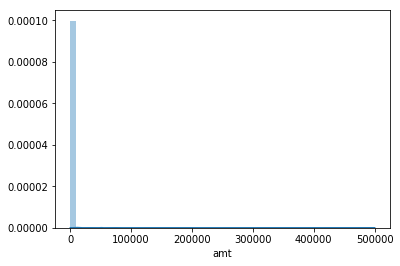

In [57]:
sql_expr = """
SELECT transaction_amt AS amt
FROM indiv_sample
WHERE transaction_amt > 0;
"""
result = pd.read_sql(sql_expr, engine)

_ = sns.distplot(result['amt'])

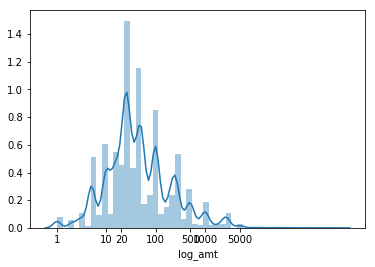

In [59]:
sql_expr = """
SELECT LOG(transaction_amt) AS log_amt
FROM indiv_sample
WHERE transaction_amt > 0;
"""
result = pd.read_sql(sql_expr, engine)
df = result['log_amt']
sns.distplot(df.astype('float'))
scales = np.array([1, 10, 20,  100, 500,  1000, 5000])
_ = plt.xticks(np.log10(scales), scales)

## Examining the Tail

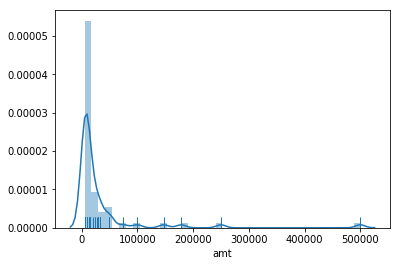

In [60]:
sql_expr = """
SELECT transaction_amt AS amt
FROM indiv_sample
WHERE transaction_amt > 5000;
"""
result = pd.read_sql(sql_expr, engine)

_ = sns.distplot(result['amt'], rug=True)

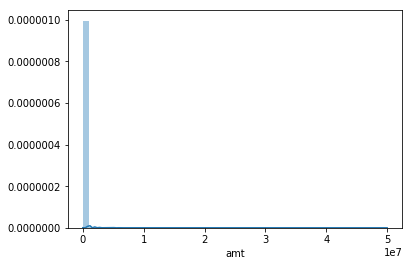

In [61]:
sql_expr = """
SELECT transaction_amt AS amt
FROM individual
WHERE transaction_amt > 5000;
"""
result = pd.read_sql(sql_expr, engine)

_ = sns.distplot(result['amt'])

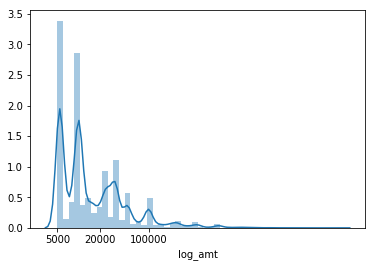

In [62]:
sql_expr = """
SELECT log(transaction_amt) AS log_amt
FROM individual
WHERE transaction_amt > 5000;
"""
result = pd.read_sql(sql_expr, engine)

sns.distplot(result['log_amt'])
scales = np.array([5000, 20000, 100000])
_ = plt.xticks(np.log10(scales), scales)

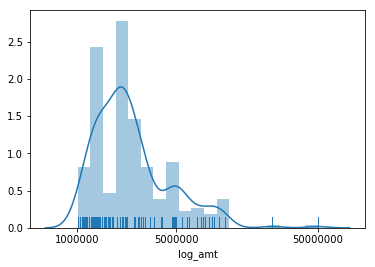

In [73]:
sql_expr = """
SELECT log(transaction_amt) AS log_amt
FROM individual
WHERE transaction_amt > 1000000;
"""
result = pd.read_sql(sql_expr, engine)

sns.distplot(result['log_amt'], rug=True)
scales = np.array([1000000, 5000000, 50000000])
_ = plt.xticks(np.log10(scales), scales)

#### `CASE` statements: SQL conditionals in the `FROM` clause
What about smaller donations?

In [63]:
sql_expr = """
SELECT name, state, cmte_id,
       transaction_amt, LOG(transaction_amt)
FROM indiv_sample
WHERE transaction_amt < 10
LIMIT 10;
"""
try:
    display(pd.read_sql(sql_expr, engine))
except Exception as e:
    print(e)

(psycopg2.DataError) cannot take logarithm of a negative number
 [SQL: '\nSELECT name, state, cmte_id,\n       transaction_amt, LOG(transaction_amt)\nFROM indiv_sample\nWHERE transaction_amt < 10\nLIMIT 10;\n'] (Background on this error at: http://sqlalche.me/e/9h9h)


Uh oh, log is not defined for numbers <= 0! We need a *conditional* statement in the `select` clause to decide what function to call. We can use SQL's `case` construct for that.

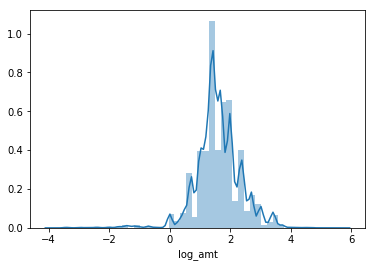

In [38]:
sql_expr = """
SELECT transaction_amt,
    CASE WHEN transaction_amt > 0 THEN log(transaction_amt)
         WHEN transaction_amt = 0 THEN 0
         ELSE -1*(log(abs(transaction_amt)))
    END AS log_amt
FROM indiv_sample
"""
try:
    result = pd.read_sql(sql_expr, engine)
    sns.distplot(result['log_amt'])
except Exception as e:
    print(e)

## Who donated the most?

In [39]:
sql_expr = """
SELECT transaction_amt, cmte_id, transaction_dt, name, city, state, memo_text, occupation 
FROM individual 
ORDER BY transaction_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)


,transaction_amt,cmte_id,transaction_dt,name,city,state,memo_text,occupation
0,50000000,C00616078,06162016,STATWARE INC. AND OTHER FIRMS,CENTERBOOK,CT,None,None
1,23787000,C00010603,11072016,HILLARY VICTORY FUND,NEW YORK,NY,None,None
2,11000000,C00575373,04102015,"MERCER, ROBERT",EAST SETAUKET,NY,None,FINANCE
3,11000000,C00547349,10262016,"STEYER, THOMAS F.",SAN FRANCISCO,CA,None,FOUNDER
4,10000000,C00571703,08292016,"ADELSON, MIRIAM DR.",LAS VEGAS,NV,None,PHYSICIAN
5,10000000,C00575431,04092015,"NEUGEBAUER, TOBY",DORADO,PR,None,INVESTOR
6,10000000,C00571703,08262016,"ADELSON, SHELDON G. MR.",LAS VEGAS,NV,None,CHAIRMAN & CEO
7,10000000,C00571372,10212015,C.V. STARR & CO INC,NEW YORK,NY,None,None
8,10000000,C00504530,08292016,"ADELSON, MIRIAM",LAS VEGAS,NV,None,PHYSICIAN
9,10000000,C00504530,08292016,"ADELSON, SHELDON",LAS VEGAS,NV,None,CHAIRMAN


## Grouping Contributions by Name

In [40]:
sql_expr = """
SELECT name, SUM(transaction_amt) AS total_amt
FROM individual 
GROUP BY name
ORDER BY total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,name,total_amt
0,"STEYER, THOMAS F.",90044644
1,STATWARE INC. AND OTHER FIRMS,50000000
2,"EYCHANER, FRED",37921658
3,HILLARY VICTORY FUND,35379700
4,NEXTGEN CLIMATE ACTION COMMITTEE,31213354
5,"ADELSON, MIRIAM",27936800
6,"SUSSMAN, DONALD",25642400
7,"SOROS, GEORGE",22364011
8,SENATE LEADERSHIP FUND,22355200
9,"BLOOMBERG, MICHAEL R.",21675924


## Going Local with `WHERE`

In [41]:
sql_expr = """
SELECT name, SUM(transaction_amt) AS total_amt
FROM individual
WHERE city = 'SAN FRANCISCO'
GROUP BY name
ORDER BY total_amt DESC
LIMIT 20;
"""
pd.read_sql(sql_expr, engine)

,name,total_amt
0,"STEYER, THOMAS F.",89726944
1,"MOSKOVITZ, DUSTIN",14111000
2,"TUNA, CARI",6623000
3,"SANDLER, HERBERT M.",5494400
4,"THIEL, PETER",4066700
5,"OBERNDORF, WILLIAM E. MR.",2416106
6,"SCHWAB, HELEN O. MRS.",1502700
7,"OBERNDORF, WILLIAM E.",1371200
8,WENDT FAMILY TRUST,1350000
9,AMERICAN PACIFIC INTERNATIONAL CAPITAL INC.,1300000


In [42]:
sql_expr = """
SELECT name, SUM(transaction_amt) AS total_amt
FROM individual
WHERE city = 'BERKELEY'
GROUP BY name
ORDER BY total_amt DESC
LIMIT 20;
"""
pd.read_sql(sql_expr, engine)

,name,total_amt
0,"SHENKER, SCOTT",1334600
1,"SIMONS, NAT",363400
2,"SIMONS, NATHANIEL",224700
3,"WILKINS, MICHAEL IAN",186681
4,"HEADLEY, MARK",161700
5,"GUND, LOUISE LAIDLAW",148083
6,"SLATER, AMY",126340
7,"HEADLEY, MARK W.",115400
8,"HEADLEY, MARK W",115200
9,"BERLEKAMP, ELWYN",114900


# Named Queries: Views and CTEs

Up to now we've looked at a single query at a time. SQL also allows us to nest queries in various ways. In this section we look at the cleaner examples of how to do this in SQL: views and Common Table Expressions (CTEs).

Will not discuss in lecture. Provided for your reference.

## Views
In earlier examples, we created new tables and populated them from the result of queries over stored tables. There are two main drawbacks of that approach that may concern us in some cases:

1. The new table **uses up storage**, even though it is recomputable from other tables.
1. **Out of date**. The stored output will not reflect changes in the input. 

For this reason, SQL provides a notion of logical *views*: these are basically named queries that are re-evaluated upon each reference. 


The syntax is straightforward:

```sql
CREATE VIEW <name> AS
<SELECT statement>;
```

The resulting view `<name>` can be used in an `SELECT` query, but **not** in an `INSERT`, `DELETE` or `UPDATE` query!

As an example, we might want a view that stores just some summary statistics of `transaction_amt`s for each date:

In [43]:
try:
    engine.execute("""
        DROP VIEW IF EXISTS date_stats;
        """)

    engine.execute("""
        CREATE VIEW date_stats AS
        SELECT 
            transaction_dt AS day,
            min(transaction_amt), 
            avg(transaction_amt), 
            stddev(transaction_amt),
            max(transaction_amt)
        FROM individual
        GROUP BY transaction_dt
        ORDER BY day;
        """)
    
    sql_expr = """
        SELECT * from date_stats limit 5;
        """
    
    display(pd.read_sql(sql_expr, engine))
    
except Exception as e:
    print("In the shared Data 100 Postgres server you not allowed to create views.\n\n")
    print(e)


,day,min,avg,stddev,max
0,01012014,1385,1942.500000,788.424061,2500
1,01012015,-2600,188.471556,880.059579,30000
2,01012016,-2700,198.206209,2545.985243,250000
3,01012017,100,550.000000,636.396103,1000
4,01022015,-2600,1700.954743,85215.579499,5000000


**Notice that this did not create a table: **

In [44]:
inspector.get_table_names()

['ccl',
 'cm',
 'cn',
 'indiv_sample',
 'indiv_sample2',
 'individual',
 'my_matrix',
 'oppexp',
 'pas',
 'profs',
 'students',
 'tips',
 'sailors',
 'boats',
 'reserves']

**Instead it created a view:** (if you are allowed to create views)

In [45]:
inspector.get_view_names()

['rando', 'date_stats']

### Views are not materialized

Let's create a random table and we will even seed the random number generator.

```sql
DROP VIEW IF EXISTS rando;

SELECT setseed(0.3);

CREATE VIEW rando(rownum, rnd) AS
SELECT rownum, round(random())::INTEGER
FROM generate_series(1,50) AS ind(rownum)
```

What is the sum of the rows in Random:

In [50]:
sql_expr = """
SELECT SUM(rnd) FROM rando;
"""
pd.read_sql(sql_expr, engine)

,sum
0,23


What was that value again?


In [51]:
sql_expr = """
SELECT SUM(rnd) FROM rando;
"""
pd.read_sql(sql_expr, engine)

,sum
0,22


--- 
</br></br></br>

The value changes with each invocation.

## Too Many Views

Views can help:
* Simplify queries
* Make complex queries more readable 
* Share "sql programs" with others 

Problem:
* Creating a new view for each (exploratory) query will result in a lot of views! 
* views like: `temp1`, `temp1_joey`, `temp1_joey_fixed`, ... 
* Often you will not be allowed to create views.

** We need a mechanism to decompose query into views for the scope of a single query.**

## Common Table Expressions (`WITH`)

Think of these as a view that exists only during the query.

If we're only going to use a view within a single query, it is a little inelegant to `CREATE` it, and then have to `DROP` it later to recycle the view name.

*Common Table Expressions* (CTEs) are like views that we use on-the-fly. (If you know about lambdas in Python, you can think of CTEs as lambda views.) The syntax for CTEs is to use a `WITH` clause in front of the query: 

`WITH <name> [(renamed columns)] AS 
  (<SELECT statement>) 
  [, <name2> AS (<SELECT statement>)...]`

If you need multiple CTEs, you separate them with commas.
We can rewrite our query above without a view as follows:

In [52]:
sql_expr = """
WITH per_day_stats AS (
    SELECT 
        to_date(transaction_dt, 'MMDDYYYY') as day, -- Date Parsing
        min(transaction_amt), 
        avg(transaction_amt), 
        stddev(transaction_amt),
        max(transaction_amt)
    FROM indiv_sample
    GROUP BY transaction_dt
)    
SELECT day, stddev, max - min AS spread
FROM per_day_stats
WHERE stddev IS NOT NULL
ORDER by stddev DESC
LIMIT 5
"""
pd.read_sql(sql_expr, engine)

,day,stddev,spread
0,2015-01-29,156888.687067,499975
1,2016-03-07,25722.240498,100003
2,2015-02-12,20132.919349,49998
3,2015-04-28,11091.966531,33390
4,2016-07-13,10412.932316,49995


# Joins

Suppose now we want to determine which committees received the most money

In [53]:
sql_expr = """
SELECT cmte_id, SUM(transaction_amt) AS total_amt
FROM individual 
GROUP BY cmte_id
ORDER BY total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,cmte_id,total_amt
0,C00586537,428422747
1,C00401224,314682670
2,C00575795,293602014
3,C00495861,183763164
4,C00571372,132142087
5,C00003418,123195123
6,C00618389,107943772
7,C00571703,104275579
8,C00547349,92536032
9,C00010603,89932788


## What are the names of these Committees?

In [54]:
pd.DataFrame(inspector.get_columns("individual")).set_index('name')

,autoincrement,default,nullable,type
name,,,,
cmte_id,False,None,True,VARCHAR(9)
amndt_ind,False,None,True,CHAR(1)
rpt_tp,False,None,True,VARCHAR(3)
transaction_pgi,False,None,True,CHAR(5)
image_num,False,None,True,BIGINT
transaction_tp,False,None,True,VARCHAR(3)
entity_tp,False,None,True,VARCHAR(3)
name,False,None,True,TEXT
city,False,None,True,TEXT


In [55]:
pd.DataFrame(inspector.get_columns("cm")).set_index('name')

,autoincrement,default,nullable,type
name,,,,
cmte_id,False,None,True,VARCHAR(9)
cmte_nm,False,None,True,TEXT
tres_nm,False,None,True,TEXT
cmte_st1,False,None,True,TEXT
cmte_st2,False,None,True,TEXT
cmte_city,False,None,True,TEXT
cmte_st,False,None,True,VARCHAR(2)
cmte_zip,False,None,True,VARCHAR(10)
cmte_dsgn,False,None,True,CHAR(1)


We can join the committee description to get the names of the committees that received the most funds. 

In [56]:
sql_expr = """
WITH indv2cm AS
(
    SELECT cmte_id, SUM(transaction_amt) AS total_amt
    FROM individual
    GROUP BY cmte_id
    ORDER BY total_amt DESC
)
SELECT cm.cmte_nm, indv2cm.total_amt 
FROM cm, indv2cm
WHERE cm.cmte_id = indv2cm.cmte_id
ORDER BY indv2cm.total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,cmte_nm,total_amt
0,HILLARY VICTORY FUND,428422747
1,ACTBLUE,314682670
2,HILLARY FOR AMERICA,293602014
3,PRIORITIES USA ACTION,183763164
4,RIGHT TO RISE USA,132142087
5,REPUBLICAN NATIONAL COMMITTEE,123195123
6,TRUMP VICTORY,107943772
7,SENATE LEADERSHIP FUND,104275579
8,NEXTGEN CLIMATE ACTION COMMITTEE,92536032
9,DNC SERVICES CORP./DEM. NAT'L COMMITTEE,89932788


## Which candidate received the most

In [57]:
pd.DataFrame(inspector.get_columns("cn")).set_index('name')

,autoincrement,default,nullable,type
name,,,,
cand_id,False,None,True,VARCHAR(9)
cand_name,False,None,True,TEXT
cand_pty_affiliation,False,None,True,VARCHAR(3)
cand_election_yr,False,None,True,INTEGER
cand_office_st,False,None,True,VARCHAR(2)
cand_office,False,None,True,CHAR(1)
cand_office_district,False,None,True,INTEGER
cand_ici,False,None,True,CHAR(1)
cand_status,False,None,True,CHAR(1)


### Candidate Committee Linkage Table

In [58]:
pd.DataFrame(inspector.get_columns("ccl")).set_index('name')

,autoincrement,default,nullable,type
name,,,,
cand_id,False,None,True,VARCHAR(9)
cand_election_yr,False,None,True,INTEGER
fec_election_yr,False,None,True,INTEGER
cmte_id,False,None,True,VARCHAR(9)
cmte_tp,False,None,True,CHAR(1)
cmte_dsgn,False,None,True,CHAR(1)
linkage_id,False,None,True,INTEGER


### Joining Aggregated Indiv - CCL - CN

In [59]:
sql_expr = """
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id 
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,cand_name,total_amt
0,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",293602014
1,"SANDERS, BERNARD",84741223
2,"TRUMP, DONALD J. / MICHAEL R. PENCE",65329708
3,"RUBIO, MARCO",60770391
4,"RYAN, PAUL D.",58792561
5,"CRUZ, RAFAEL EDWARD ""TED""",54016803
6,"BUSH, JEB",33215298
7,"CARSON, BENJAMIN S SR MD",27720768
8,"VAN HOLLEN, CHRIS",27254529
9,"PORTMAN, ROB",21122605


### Localized Join for CA

In [60]:
sql_expr = """
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id AND
    indiv.state = 'CA'
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,cand_name,total_amt
0,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",64312114
1,"SANDERS, BERNARD",18755158
2,"HARRIS, KAMALA D",9217342
3,"RUBIO, MARCO",8290342
4,"MCCARTHY, KEVIN",5885992
5,"CRUZ, RAFAEL EDWARD ""TED""",5477703
6,"RYAN, PAUL D.",5419340
7,"TRUMP, DONALD J. / MICHAEL R. PENCE",5183688
8,"MASTO, CATHERINE CORTEZ",3405938
9,"BUSH, JEB",3356045


### Localized Join for FL

In [61]:
sql_expr = """
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id AND
    indiv.state = 'FL'
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,cand_name,total_amt
0,"RUBIO, MARCO",17355941
1,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",15315796
2,"PERKINS, RANDY",10315395
3,"MURPHY, PATRICK E",7926526
4,"BUSH, JEB",7291164
5,"RYAN, PAUL D.",6129278
6,"TRUMP, DONALD J. / MICHAEL R. PENCE",5072826
7,"ROONEY, FRANCIS",4280801
8,"SANDERS, BERNARD",3053688
9,"CRUZ, RAFAEL EDWARD ""TED""",2741375


### Localized Join for TX

In [62]:
sql_expr = """
SELECT cn.cand_name, SUM(indiv.transaction_amt) AS total_amt
FROM individual AS indiv, ccl, cn
WHERE indiv.cmte_id = ccl.cmte_id AND
    ccl.cand_id = cn.cand_id AND
    indiv.state = 'TX'
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 10
"""
pd.read_sql(sql_expr, engine)

,cand_name,total_amt
0,"CRUZ, RAFAEL EDWARD ""TED""",20464749
1,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",16124458
2,"RYAN, PAUL D.",7905676
3,"TRUMP, DONALD J. / MICHAEL R. PENCE",5763918
4,"RUBIO, MARCO",4998601
5,"BUSH, JEB",3904580
6,"CRUZ, RAFAEL EDWARD TED",3310330
7,"CARSON, BENJAMIN S SR MD",3291938
8,"SANDERS, BERNARD",3135692
9,"DEWHURST, DAVID H",2501335


## Tracking Direct Committee Contributions

In [63]:
sql_expr = """
SELECT cm.cmte_nm, SUM(transaction_amt) AS total_amt
FROM pas, cm
WHERE pas.cmte_id = cm.cmte_id
GROUP BY cm.cmte_nm
ORDER BY total_amt DESC
LIMIT 5
"""
pd.read_sql(sql_expr, engine) 

,cmte_nm,total_amt
0,PRIORITIES USA ACTION,133443133
1,DSCC,118795008
2,RIGHT TO RISE USA,86817138
3,SENATE LEADERSHIP FUND,85994270
4,DCCC,84368850


In [64]:
sql_expr = """
SELECT cn.cand_name, SUM(transaction_amt) AS total_amt
FROM pas, cn
WHERE pas.cand_id = cn.cand_id
GROUP BY cn.cand_name
ORDER BY total_amt DESC
LIMIT 5
"""
pd.read_sql(sql_expr, engine) 

,cand_name,total_amt
0,"TRUMP, DONALD J. / MICHAEL R. PENCE",322303387
1,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",191839266
2,"BUSH, JEB",87255752
3,"TOOMEY, PATRICK JOSEPH",73347997
4,"AYOTTE, KELLY A",64513126
